One page rules fantasy regiments

In [1827]:
import random

In [1828]:
def quality_test(quality, modifier=0):
    roll = random.randint(1, 6)
    return (roll + modifier >= quality or roll == 6) and roll != 1

In [1829]:
def shoot(quality, models, ap, defense):
    # roll to hit
    hits = 0
    for i in range(models):
        if quality_test(quality, modifier=0):
            hits += 1
    
    wounds = 0
    for i in range(hits):
        roll = random.randint(1, 6)
        if (roll - ap < defense or roll == 1) and roll != 6:
            wounds += 1
    return wounds

In [1830]:
shoot(4, 5, 0, 5)

0

In [1831]:
def mc(func, times=10000):
    total = 0
    for i in range(times):
        total += func()
    return total / times

In [1832]:
mc(lambda: shoot(4, 5, 0, 5), 100)

1.5

In [1833]:
# 10 warriors vs 5 veterans
mc(lambda: shoot(3, 5, 0, 5), 100)

2.19

In [1834]:
mc(lambda: shoot(4, 10, 0, 4), 100)

2.52

In [1835]:
# 5 veterans vs 10 human infantrymen
mc(lambda: shoot(3, 5, 1, 5), 100)

2.74

In [1836]:
mc(lambda: shoot(5, 10, 0, 4), 100)

1.76

In [1837]:
1.66/2.77

0.5992779783393501

In [1838]:
class Unit:
    def __init__(self, quality, defense, models, width, ap=0, bonus=0):
        self.quality = quality
        self.defense = defense
        self.models = models
        self.starting_models = models
        self.width = width
        self.wavering = False
        self.ap = ap
        self.melee_bonus = bonus
    
    def full_rows(self):
        return self.models // self.width
    
    def under_half(self):
        return self.models / self.starting_models <= 0.5

In [1839]:
import copy

In [1840]:
def to_the_death(a, b):
    while True:
        # A attacks B
        a_wounds = shoot(a.quality, min(a.models, 10), 0, b.defense)
        b.models -= a_wounds
#         print(a_wounds)
        
        if b.models <= 0:
            return 1
        
        # B strikes back
        b_wounds = shoot(b.quality, min(b.models, 10), 0, a.defense)
        a.models -= b_wounds
        
#         print(b_wounds)

        if a.models <= 0:
            return 0
        
        
        a_score = a_wounds + a.full_rows() + a.melee_bonus
        b_score = b_wounds + b.full_rows() + b.melee_bonus
        
        if a_score > b_score:
            loser = b
        elif b_score > a_score:
            loser = a
        else:
            loser = None
        
        if loser:
            if not quality_test(loser.quality):
                if loser.under_half():
                    loser.models = 0
                else:
                    loser.wavering = True
        
        if b.models <= 0:
            return 1
        if a.models <= 0:
            return 0

In [1841]:
dwarves = Unit(4, 5, 20, 5)
beards = Unit(3, 4, 5, 5, ap=1)
humans = Unit(5, 5, 20, 5)

In [1842]:
to_the_death(copy.deepcopy(dwarves), copy.deepcopy(humans))

1

In [1843]:
mc(lambda: to_the_death(copy.deepcopy(Unit(5, 5, 20, 5, bonus=2)), copy.deepcopy(Unit(5, 5, 20, 5, bonus=2))), 100)

0.6

Unit(5, 5, 20, 5, bonus=0) mirror, with different bonuses
0 both: 0.55
a1: 0.65
a2: 0.73
d1: 0.44
d2: 0.36
a2d2: 0.55


In [1924]:
from opr_structs import *
from opr_logic import *

Reimplementation with units as point masses.

Assume that units are simply spheres of 1" radius

In [1844]:
def merge_rules(a, b):
    merged = {}
    for r in a.keys():
        total = a.get(r, 0) + b.get(r, 0)
        merged[r] = total

    for r in b.keys():
        if r in merged:
            continue
        merged[r] = b[r]
    return merged

In [1845]:
a = {"Tough":3, "Deadly":2, "Fear":0}
b = {"Deadly": 5, "Flying":0}
merge_rules(a, b)

{'Tough': 3, 'Deadly': 7, 'Fear': 0, 'Flying': 0}

In [1846]:
class Attack:
    def __init__(self, quality, rules=None):
        if rules is None:
            rules = {}
        self.quality = quality
        self.rules = rules
    
    def __repr__(self):
        return f"Attack({self.quality}, {self.rules})"

In [1847]:
class Weapon:
    def __init__(self, attacks, rules=None):
        if rules is None:
            rules = {}
        
        self.attacks = attacks
        self.rules = rules
    
    @property
    def range(self):
        return self.rules.get("Range", 0)
    
    @property
    def melee(self):
        return self.range == 0
    

In [1848]:
class Model:
    def __init__(self, quality, defense, equipment, rules=None):
        if rules is None:
            rules = {}
        self.quality = quality
        self.defense = defense
        self.equipment = equipment
        self.rules = rules
    
    def __repr__(self):
        return f"Model({self.quality}, {self.defense}, {self.equipment}, {self.rules})"

In [1849]:
class Unit:
    def __init__(self, models, width, rules=None, name=None):
        if rules is None:
            rules = {}
        self.models = models
        self.width = width
        self.rules: dict = rules
        self.starting_models = len(self.models)
        self.accumulated_wounds = 0
        self.x = 0
        self.y = 0
        self.controller = None
        if name is None:
            self.name = f"Unit {random.randint(0, 1000)}"
        else:
            self.name = name
    
    def __repr__(self):
        return f"Unit({self.name} ({len(self.models)}/{self.starting_models})({self.x:.1f},{self.y:.1f})"

    @property
    def full_rows(self):
        return len(self.models) // self.width
    
    @property
    def under_half(self):
        first_tough = self.models[0].rules.get("Tough", 1)
        if len(self.models) == 1 and first_tough != 1:
            return self.accumulated_wounds / first_tough <= 0.5
        return len(self.models) / self.starting_models <= 0.5
    
    @property
    def alive(self):
        return len(self.models) > 0

    @property
    def defense(self):
        return self.models[-1].defense
    
    @property
    def command(self):
        total = 0
        for model in self.models:
            if "Command" in model.rules:
                total += 1
        return total
    
    @property
    def is_melee(self):
        for model in self.models:
            for equipment in model.equipment:
                if not equipment.melee:
                    return False
        return True
    
    @property
    def is_hybrid(self):
        # TODO fire breath
        # Melee takes precidence
        if self.is_melee:
            return False
        
        all_ranged = []
        all_melee = []
        for model in self.models:
            for equipment in model.equipment:
                if equipment.melee:
                    all_melee.append(equipment)
                else:
                    all_ranged.append(equipment)
        
        if len(all_melee) > len(all_ranged) * 2:
            return True # if we just have a single model with a ranged weapon, we're hybrid
        
        # short ranged (12" or less) are hybrid (skip single model)
        if len([e for e in all_ranged if e.range <= 12]) > 1:
            return True
        
        return False
    
    @property
    def is_ranged(self):
        return not self.is_melee and not self.is_hybrid
    
    @property
    def speed(self):
        _speed = 6
        if "Slow" in self.rules or any(["Slow" in model.rules for model in self.models]):
            _speed -= 2
        elif "Fast" in self.rules or all(["Fast" in model.rules for model in self.models]):
            _speed += 2
        if "Immobile" in self.rules or any(["Immobile" in model.rules for model in self.models]):
            _speed = 0
        return _speed
        
    
    def apply_wounds(self, wounds):
        pass
    
    def apply_hits(self, hits):
        pass
    
    def morale_test(self):
        # If the unit is wavering, automatically fail the test
        if "Wavering" in self.rules:
            return False
        
        # pick a model to do the 
        # If there are heroes and their quality is higher, use it for quality tests
        # TODO pick optimal model, by default just do the first
        morale_model = self.models[0]
        
        bonus = 0
        if "Fearless" in morale_model.rules:
            bonus += 1
        
        return quality_test(morale_model.quality, bonus)
    
    def do_morale(self):
        print(f"{self.name} doing morale test")
        if not self.morale_test():
            print(f"{self.name} failed morale test")
            if self.under_half:
                self.models.clear()
                self.rules["Routed"] = True
                print(f"{self.name} routed!")
            else:
                self.rules["Wavering"] = True
        
    def do_ranged_morale(self):
        print(f"{self.name} doing ranged morale test")
        if not self.morale_test():
            print(f"{self.name} failed ranged morale test")
            self.rules["Wavering"] = True

In [1850]:
a = [0, 1, 2, 3]
a[:6]

[0, 1, 2, 3]

In [1851]:
def get_melee_attacks(unit, charging, against):
    # first two rows attack
    attacking_models = unit.models[:unit.width * 2]
    
#     charging = aga
    # TODO phalanx

    # gather the attacks
    attacks = []
    for model in attacking_models:
        # TODO impact
        if "Impact" in model.rules:
            for i in range(model.rules["Impact"]):
                attacks.append(Attack(2, rules={"Impact":0}))
        # get the attacks from melee weapons, ie range == 0
        for weapon in model.equipment:
            if not weapon.melee:
                continue
            
#             print(weapon)
            # TODO furious
            num_attacks = weapon.attacks
#             if 
            for _ in range(num_attacks):
                attacks.append(Attack(model.quality, 
                                      rules=merge_rules(merge_rules(weapon.rules, model.rules), unit.rules)))
    
    return attacks

In [1852]:
def models_for(model, count, heros=None):
    if heros is None:
        heros = []
    models = []
    models.extend(heros)
    for i in range(count):
        models.append(model)
    return models

In [1853]:
hand_weapon = Weapon(1)
rifle = Weapon(1, {"Range": 18, "AP": 1})
dwarf = Model(4, 5, [hand_weapon])
rifle_dwarf = Model(4, 5, [rifle, hand_weapon])
dwarf_marksmen = Unit(models_for(rifle_dwarf, 5), 5)
dwarves = Unit(models_for(dwarf, 10), 5) # TODO rules
dwarf_marksmen.is_melee, dwarves.is_melee, dwarf_marksmen.is_hybrid

(False, True, False)

In [1854]:
throwing_axes = Weapon(2, {"Range": 12})
ranger_dwarf = Model(4, 5, [throwing_axes, hand_weapon])
ranger_dwarves = Unit(models_for(ranger_dwarf, 10), 5)
ranger_dwarves.is_melee, ranger_dwarves.is_hybrid, ranger_dwarves.is_melee

(False, True, False)

In [1855]:
attacks = get_melee_attacks(dwarves, False, dwarves)
attacks, len(attacks)

([Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {})],
 10)

In [1856]:
hero_weapon = Weapon(3, {"AP":1})
dwarf_champion = Model(3, 4, [hero_weapon], {"Hero":0, "Tough":3, "Slow":0, "Fearless":0,})
dwarves_with_hero = Unit(models_for(dwarf, 10, [dwarf_champion]), 5) # TODO rules

In [1857]:
attacks = get_melee_attacks(dwarves_with_hero, False, dwarves)
attacks, len(attacks)

([Attack(3, {'AP': 1, 'Hero': 0, 'Tough': 3, 'Slow': 0, 'Fearless': 0}),
  Attack(3, {'AP': 1, 'Hero': 0, 'Tough': 3, 'Slow': 0, 'Fearless': 0}),
  Attack(3, {'AP': 1, 'Hero': 0, 'Tough': 3, 'Slow': 0, 'Fearless': 0}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {}),
  Attack(4, {})],
 12)

In [1858]:
golem = Model(4, 3, [hero_weapon], {"Tough":3})
golems = Unit(models_for(golem, 3), 3)

In [1859]:
attacks = get_melee_attacks(golems, False, dwarves)
attacks, len(attacks)

([Attack(4, {'AP': 1, 'Tough': 3}),
  Attack(4, {'AP': 1, 'Tough': 3}),
  Attack(4, {'AP': 1, 'Tough': 3}),
  Attack(4, {'AP': 1, 'Tough': 3}),
  Attack(4, {'AP': 1, 'Tough': 3}),
  Attack(4, {'AP': 1, 'Tough': 3}),
  Attack(4, {'AP': 1, 'Tough': 3}),
  Attack(4, {'AP': 1, 'Tough': 3}),
  Attack(4, {'AP': 1, 'Tough': 3})],
 9)

In [1860]:
class Hit:
    def __init__(self, rules=None):
        if rules is None:
            rules = {}
        self.rules = rules
    
    def __repr__(self):
        return f"Hit({self.rules})"

In [1861]:
def roll_attacks(attacks, target):
    hits = []
    for attack in attacks:
        # TODO Fatigued, wavering
        bonus = attack.rules.get("Bonus", 0)
        if "Fatigued" in attack.rules:
            bonus -= 999
        if "Wavering" in attack.rules:
            bonus -= 999
        # do the thing
        roll = random.randint(1, 6)
        success = (roll + bonus >= attack.quality or roll == 6) and roll != 1
        if not success:
            continue
        
        
        if roll == 6:
            # do special stuff here
            # rending
            if "Rending" in attack.rules:
                attack.rules["Rended"] = 0
                attack.rules["AP"] = 4
            
            # TODO fix this: it should just add three wounds, not deadly
            if "Poison" in attack.rules:
                attack.rules["Poisoned"] = 0
#                 attack.rules["Deadly"] = attack.rules.get("Deadly", 1) * 3
            
        # add the hits
        # TODO 
        for _ in range(attack.rules.get("Blast", 1)):
            hits.append(Hit(attack.rules))

    return hits

In [1862]:
roll_attacks(attacks, dwarves)

[Hit({'AP': 1, 'Tough': 3}),
 Hit({'AP': 1, 'Tough': 3}),
 Hit({'AP': 1, 'Tough': 3}),
 Hit({'AP': 1, 'Tough': 3})]

In [1863]:
def apply_hits(unit, hits):
    # turn hits into wounds via defending
    # make defense rolls
    wounds = []
    for hit in hits:
        roll = random.randint(1, 6)
        success = (roll - hit.rules.get("AP", 0) >= unit.defense or roll == 6) and roll != 1
        if success:
            # defended, skip its abilities
            continue
        
        # add the wounds from the hit
        wounds.append(hit.rules)
    return wounds

In [1864]:
apply_hits(dwarves, [Hit(), Hit(), Hit(), Hit()])

[{}, {}]

In [1865]:
def apply_wounds(unit: Unit, wounds):
    total = 0
    for wound in wounds:
        current_model = unit.models[-1]
        # apply the wound to the unit.
        count = wound.get("Deadly", 1) # TODO Deadly
        
        if "Regeneration" in unit.models[-1].rules:
            for i in range(count):
                roll = random.randint(1, 6)
                if "Poison" in wound:
                    roll -= 1
                if "Rending" in wound:
                    roll -= 1
                
                if roll >= 5:
                    count -= 1
                    print("Regenerated")

        unit.accumulated_wounds += count
        total += count

        toughness = current_model.rules.get("Tough", 1)
        if unit.accumulated_wounds >= toughness:
            unit.models.pop()
            unit.accumulated_wounds = 0
            # if all the models are dead, we're done here
            if not unit.models:
                return total

    return total

In [1866]:
dwarves = Unit(models_for(dwarf, 10), 5) # TODO rules
apply_wounds(dwarves, [{}, {}, {}])

3

In [1867]:
len(dwarves.models)

7

In [1868]:
dwarves_with_hero = Unit(models_for(dwarf, 10, [dwarf_champion]), 5) # TODO rules
apply_wounds(dwarves_with_hero, [{}, {}, {}])

3

In [1869]:
len(dwarves_with_hero.models)

8

In [1870]:
golems = Unit(models_for(golem, 3), 3)
apply_wounds(golems, [{}, {}, {}, {}])

4

In [1871]:
len(golems.models), golems.accumulated_wounds

(2, 1)

In [1872]:
golems = Unit(models_for(golem, 1), 3)
apply_wounds(golems, [{}, {}, {}, {}])
len(golems.models)

0

In [1873]:
def strike(attacker, defender, charging):
    print(f"{attacker} strikes {defender}")
    # determine attacks
    attacks = get_melee_attacks(attacker, charging, defender)
    print(f"{len(attacks)} attacks")
    # roll to hit
    hits = roll_attacks(attacks, defender)
    print(f"{len(hits)} hits")
    # roll to block
    # TODO do hits and wounds at the same time, to accurately deal with heros
    wounds = apply_hits(defender, hits)
    # remove casualties
    total_wounds = apply_wounds(defender, wounds)
    print(f"{total_wounds} wounds")
    
    # apply fatigued
    attacker.rules["Fatigued"] = True
    
    return total_wounds

In [1874]:
def do_melee(attacker, defender):
    a_wounds = strike(attacker, defender, True)
    if not defender.models:
        # enemy is dead, we're done
        print(f"{defender} has been slain!")
        return
    
    d_wounds = strike(defender, attacker, False)
    if not attacker.models:
        # enemy is dead, we're done
        print(f"{attacker} has been slain!")
        return
    
    # TODO musician and standard bearer
    a_score = a_wounds + attacker.full_rows + attacker.command
    d_score = d_wounds + defender.full_rows + defender.command
    
    print(f"scores: a: {a_score}, d: {d_score}")

    if a_score > d_score:
        loser = defender
    elif d_score > a_score:
        loser = attacker
    else:
        loser = None

    if loser:
        loser.do_morale()


In [1875]:
a = Unit(models_for(dwarf, 20), 5)
d = Unit(models_for(dwarf, 20), 5)
do_melee(a, d)
len(a.models), len(d.models)

Unit(Unit 441 (20/20)(0.0,0.0) strikes Unit(Unit 682 (20/20)(0.0,0.0)
10 attacks
5 hits
3 wounds
Unit(Unit 682 (17/20)(0.0,0.0) strikes Unit(Unit 441 (20/20)(0.0,0.0)
10 attacks
5 hits
2 wounds
scores: a: 6, d: 5
Unit 682 doing morale test
Unit 682 failed morale test


(18, 17)

In [1876]:
do_melee(a, d)
len(a.models), len(d.models)

Unit(Unit 441 (18/20)(0.0,0.0) strikes Unit(Unit 682 (17/20)(0.0,0.0)
10 attacks
1 hits
1 wounds
Unit(Unit 682 (16/20)(0.0,0.0) strikes Unit(Unit 441 (18/20)(0.0,0.0)
10 attacks
0 hits
0 wounds
scores: a: 4, d: 3
Unit 682 doing morale test
Unit 682 failed morale test


(18, 16)

In [1877]:
def generate_shooting_attacks(unit, distance):
    # all models attack
    attacking_models = unit.models[:]

    # gather the attacks
    attacks = []
    for model in attacking_models:
        # TODO weapon groups
        for weapon in model.equipment:
            if weapon.rules.get("Range", 0) < distance:
                continue
            

            num_attacks = weapon.attacks
            for _ in range(num_attacks):
                attacks.append(Attack(model.quality, 
                                      rules=merge_rules(merge_rules(weapon.rules, model.rules), unit.rules)))
    
    return attacks

In [1878]:
generate_shooting_attacks(dwarf_marksmen, 22)

[]

In [1879]:
def shoot(attacker, defender, distance):
    print(f"{attacker} shooting at {defender}")
    # determine attacks
    attacks = generate_shooting_attacks(attacker, distance)
    if len(attacks) == 0:
        print("Out of range")
        return 0
    print(f"{len(attacks)} attacks")
    # roll to hit
    hits = roll_attacks(attacks, defender)
    print(f"{len(hits)} hits")
    # roll to block
    # TODO do hits and wounds at the same time, to accurately deal with heros
    wounds = apply_hits(defender, hits)
    # remove casualties
    total_wounds = apply_wounds(defender, wounds)
    print(f"{total_wounds} wounds")
    
    # apply fatigued
    attacker.rules["Fatigued"] = 0
    
    return total_wounds

In [1880]:
a = Unit(models_for(rifle_dwarf, 5), 5)
d = Unit(models_for(dwarf, 20), 5)
shoot(a, d, 10)
len(a.models), len(d.models)

Unit(Unit 601 (5/5)(0.0,0.0) shooting at Unit(Unit 140 (20/20)(0.0,0.0)
5 attacks
2 hits
1 wounds


(5, 19)

In [1881]:
def do_shooting(attacker, defender, distance):
    a_wounds = shoot(attacker, defender, distance)    
    if not defender.models:
        # enemy is dead, we're done
        return
    
    if a_wounds > 0 and defender.under_half:
        defender.do_ranged_morale()

In [1882]:
a = Unit(models_for(rifle_dwarf, 5), 5)
d = Unit(models_for(dwarf, 3), 5)
do_shooting(a, d, 10)
len(a.models), len(d.models), d.rules

Unit(Unit 663 (5/5)(0.0,0.0) shooting at Unit(Unit 643 (3/3)(0.0,0.0)
5 attacks
2 hits
2 wounds
Unit 643 doing ranged morale test


(5, 1, {})

In [1883]:
hand_weapon = Weapon(1)
rifle = Weapon(1, {"Range": 24, "AP":1})
human = Model(5, 5, [hand_weapon])
human_marksman = Model(5, 5, [rifle, hand_weapon])

In [1884]:
def build_basic_army(playername):
    units = []
    for i in range(3):
        units.append(Unit(models_for(human_marksman, 5), 5, name=f"{playername} R {i}"))
    for i in range(3):
        units.append(Unit(models_for(human, 10), 5, name=f"{playername} M {i}"))
    return units
build_basic_army("P1")

[Unit(P1 R 0 (5/5)(0.0,0.0),
 Unit(P1 R 1 (5/5)(0.0,0.0),
 Unit(P1 R 2 (5/5)(0.0,0.0),
 Unit(P1 M 0 (10/10)(0.0,0.0),
 Unit(P1 M 1 (10/10)(0.0,0.0),
 Unit(P1 M 2 (10/10)(0.0,0.0)]

setup:
assign armies
place terrain
place objectives
deploy armies

main loop

pick a unit to activate
pick an action
 - hold
 - Advance
 - rush
 - charge


In [1885]:
class Player:
    def __init__(self, name, units, zone):
        self.name = name
        self.units = units
        self.zone = zone

In [1886]:
class Objective:
    def __init__(self, x, y, controller=None):
        self.x = x
        self.y = y
        self.controller = controller
    
    def __repr__(self):
        return f"Objective({self.x}, {self.y}, {self.controller})"

In [1887]:
class Battle:
    def __init__(self, players):
        self.objectives = [Objective(12, 24),Objective(36, 24),Objective(60, 24),]
        self.players = players
        self.round = 0
    
    @property
    def all_units(self):
        units = []
        for p in self.players:
            units.extend(p.units)
        return units
        return [u for u in p.units for p in self.players]

In [1888]:
p1 = Player("p1", build_basic_army("p1"), (0, 12, 0, 72))
p2 = Player("p2", build_basic_army("p2"), (36, 48, 0, 72))
battle = Battle([p1, p2])
len(battle.all_units), len(battle.players)

(12, 2)

In [1889]:
def calc_distance(x1, y1, x2, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**(1/2)

In [1890]:
calc_distance(0, 0, 1, 0), calc_distance(0, 0, 1, 1), calc_distance(0, 0, 0, 2)

(1.0, 1.4142135623730951, 2.0)

In [1891]:
def deploy(battle):
    # alternate between players, placing units
    # p1 on top, p2 on bottom
    # how do I keep track of the non-deployed units?
    
    # TODO real deployment, for now just do randomly in their zones
    # TODO Scout
    # TODO Ambush
    for p in battle.players:
        z = p.zone
        for u in p.units:
            u.x = random.randint(z[2], z[3])
            u.y = random.randint(z[0], z[1])
            u.controller = p.name

In [1892]:
deploy(battle)

In [1893]:
for u in battle.all_units:
    print(u.controller, u.x, u.y, len(u.models))

p1 34 11 5
p1 14 7 5
p1 28 1 5
p1 8 10 10
p1 48 2 10
p1 55 9 10
p2 62 42 5
p2 8 42 5
p2 14 46 5
p2 28 40 10
p2 30 37 10
p2 38 46 10


In [1894]:
for p in battle.players:
    z = p.zone
    print(p.name)
    for u in p.units:
        print(u.controller, u.x, u.y, len(u.models))

p1
p1 34 11 5
p1 14 7 5
p1 28 1 5
p1 8 10 10
p1 48 2 10
p1 55 9 10
p2
p2 62 42 5
p2 8 42 5
p2 14 46 5
p2 28 40 10
p2 30 37 10
p2 38 46 10


In [1895]:
def choose_unit_to_activate(battle, player):
    available_units = [u for u in player.units if "Activated" not in u.rules and u.alive]
    if not available_units:
        return None
    # TODO sample from a zone, with priority baseed on rules
    # for now, just sample a random unit
    return random.sample(available_units, 1)[0]

In [1896]:
choose_unit_to_activate(battle, p1)

Unit(p1 M 1 (10/10)(48.0,2.0)

In [1897]:
def get_closest(x, y, choices):
    """
    Choices must have the x and y coordinates as x and y members
    """
    closest = choices[0]
    closest_distance = calc_distance(x, y, closest.x, closest.y)
    
    for choice in choices:
        choice_distance = calc_distance(x, y, choice.x, choice.y)
        if choice_distance < closest_distance:
            closest = choice
            closest_distance = choice_distance
    return closest

In [1898]:
get_closest(0, 0, battle.objectives)

Objective(12, 24, None)

In [1899]:
import math
def get_angle_to(x, y, target):
    return math.atan2(x - target.x, y - target.y)

In [1900]:
print(get_angle_to(12, 36, Objective(12, 24, None)))
print(get_angle_to(12, 36, Objective(12, 48, None)))
print(get_angle_to(12, 36, Objective(24, 36, None)))

0.0
3.141592653589793
-1.5707963267948966


In [1901]:
def offset_at_angle(angle, distance):
    x = distance * math.sin(angle)
    y = distance * math.cos(angle)
    return (-x, -y)

In [1902]:
offset_at_angle(math.pi, 5)

(-6.123233995736766e-16, 5.0)

In [1903]:
offset_at_angle(get_angle_to(12, 36, Objective(24, 36, None)), 12)

(12.0, -7.347880794884119e-16)

In [1904]:
def choose_action_for_unit(battle, player, unit):
    # if unit is wavering/shaken, they can only hold
    if "Wavering" in unit.rules:
        return ("Hold",)
    
    # TODO decision tree for unit types, for now move towards nearest enemy unit
    enemy_units = [u for u in battle.all_units if u.controller != player.name and u.alive]
    
    closest = get_closest(unit.x, unit.y, enemy_units)
    distance_to_closest = calc_distance(unit.x, unit.y, closest.x, closest.y)
    
    # now that we have the closest, figure out the angle to them. 
    angle = get_angle_to(unit.x, unit.y, closest)
    
    speed = unit.speed
#     # TODO something do check if any/all have a rule for slow/fast
#     if "Slow" in unit.rules:
#         speed -= 2
#     if "Fast" in unit.rules:
#         speed += 2
#     if "Immobile" in unit.rules:
#         speed = 0
        
    if not unit.is_melee:
        return "Advance", speed, angle, closest
    
    if distance_to_closest <= speed * 2:
        return "Charge", closest
    
    return "Rush", speed * 2, angle

In [1905]:
choose_action_for_unit(battle, battle.players[0], battle.players[0].units[-1])

('Rush', 12, -2.9325697107835285)

In [1906]:
def execute_advance(battle, player, unit, action):
    # (Advance, desired_distance, angle, shooting target)
    # TODO validate desired distance
    # TODO movement effects
    # get the offset and apply it to the unit's position
    x_off, y_off = offset_at_angle(action[2], action[1])
    unit.x += x_off
    unit.y += y_off
    
    # TODO collisions with terrain and other units
    
    if action[3]:
        distance = calc_distance(unit.x, unit.y, action[3].x, action[3].y)
        do_shooting(unit, action[3], distance)

In [1907]:
def execute_rush(battle, player, unit, action):
    # (rush, desired_distance, angle)
    # TODO validate desired distance
    # TODO movement effects
    # get the offset and apply it to the unit's position
    x_off, y_off = offset_at_angle(action[2], action[1])
    unit.x += x_off
    unit.y += y_off
    
    # TODO collisions with terrain and other units
    
    # no combat
    

In [1908]:
def execute_charge(battle, player, unit, action):
    # (Charge, target)
    # TODO validate target range and all that
    closest = action[1]
    distance_to_closest = calc_distance(unit.x, unit.y, closest.x, closest.y)
    
    assert distance_to_closest <= unit.speed * 2
    
    # move to touch the enemy
    movement_needed = distance_to_closest - 2  # For now units are 1" spheres
    angle_needed = get_angle_to(unit.x, unit.y, closest)
    x_off, y_off = offset_at_angle(angle_needed, movement_needed)
    unit.x += x_off
    unit.y += y_off
    
    # do the combat
    do_melee(unit, closest)
    
    # back up
    x_off, y_off = offset_at_angle(angle_needed, -1)
    unit.x += x_off
    unit.y += y_off

In [1909]:
def execute_action(battle, player, unit, action):
    a_type = action[0]
    print(unit, action)

    if a_type == "Hold":
        if "Wavering" in u.rules:
            del u.rules["Wavering"]
    elif a_type == "Advance":
        execute_advance(battle, player, unit, action)
    elif a_type == "Rush":
        execute_rush(battle, player, unit, action)
    elif a_type == "Charge":
        execute_charge(battle, player, unit, action)
    else:
        print("Invalid action")
    
    unit.rules["Activated"] = True


In [1910]:
import matplotlib.pyplot as plt
def plot_battle(battle):
    y = []
    x = []
    names = []
    for u in battle.all_units:
        x.append(u.x)
        y.append(u.y)
        names.append(repr(u))
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_xlim([0, 72])
    ax.set_ylim([0, 48])
    
    for i, n in enumerate(names):
        ax.annotate(n, (x[i], y[i]))
    plt.show()

In [1911]:
def do_round(battle, first_player_index):
    battle.round += 1
    print("Starting Round", battle.round)
    # start by resetting activations
    for u in battle.all_units:
        if "Activated" in u.rules:
            del u.rules["Activated"]
    next_player_index = first_player_index
    current_player = None
#     limit = 50
    while any(["Activated" not in u.rules for u in battle.all_units if u.alive]):
#         limit -= 1
#         if limit < 0:
#             return
#         available = [u for u in battle.all_units if "Activated" not in u.rules and u.alive]
#         print(available)
        current_player = battle.players[next_player_index]
        next_player_index = (next_player_index + 1) % len(battle.players)
        
        unit = choose_unit_to_activate(battle, current_player)
        if unit is None:
            print("skipping")
            continue
        
        action = choose_action_for_unit(battle, current_player, unit)
        execute_action(battle, current_player, unit, action)
    return next_player_index # player who finished activating first

In [1912]:
from pprint import pprint

In [1913]:
p1 = Player("p1", build_basic_army("p1"), (0, 12, 0, 72))
p2 = Player("p2", build_basic_army("p2"), (36, 48, 0, 72))
battle = Battle([p1, p2])
deploy(battle)

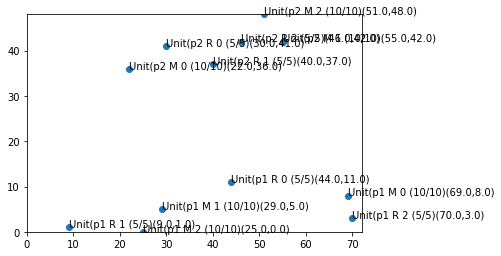

In [1914]:
plot_battle(battle)

In [1915]:
do_round(battle, 0)

Starting Round 1
Unit(p1 M 2 (10/10)(25.0,0.0) ('Rush', 12, 3.058451421701352)
Unit(p2 M 2 (10/10)(51.0,48.0) ('Rush', 12, 0.1869792699189111)
Unit(p1 R 2 (5/5)(70.0,3.0) ('Advance', 6, 2.5727743786242456, Unit(p2 M 2 (10/10)(48.8,36.2))
Unit(p1 R 2 (5/5)(66.8,8.1) shooting at Unit(p2 M 2 (10/10)(48.8,36.2)
Out of range
Unit(p2 R 0 (5/5)(30.0,41.0) ('Advance', 6, 0.20362070584192432, Unit(p1 M 2 (10/10)(24.0,12.0))
Unit(p2 R 0 (5/5)(28.8,35.1) shooting at Unit(p1 M 2 (10/10)(24.0,12.0)
5 attacks
2 hits
2 wounds
Unit(p1 R 1 (5/5)(9.0,1.0) ('Advance', 6, -2.7859567692890335, Unit(p2 M 0 (10/10)(22.0,36.0))
Unit(p1 R 1 (5/5)(11.1,6.6) shooting at Unit(p2 M 0 (10/10)(22.0,36.0)
Out of range
Unit(p2 M 0 (10/10)(22.0,36.0) ('Rush', 12, -0.08314123188844115)
Unit(p1 M 0 (10/10)(69.0,8.0) ('Rush', 12, 2.5194373382967092)
Unit(p2 R 1 (5/5)(40.0,37.0) ('Advance', 6, -0.15264932839526515, Unit(p1 R 0 (5/5)(44.0,11.0))
Unit(p2 R 1 (5/5)(40.9,31.1) shooting at Unit(p1 R 0 (5/5)(44.0,11.0)
5 attacks

0

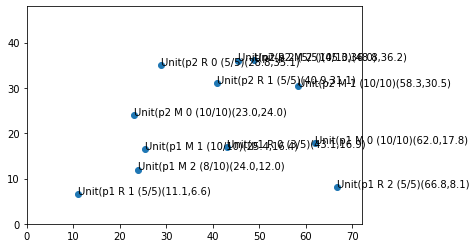

In [1916]:
plot_battle(battle)

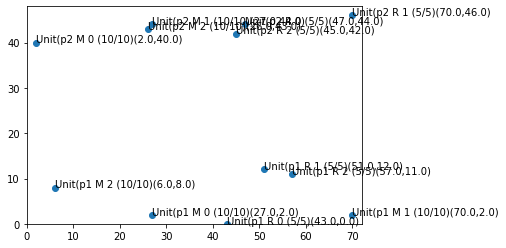

In [1917]:
p1 = Player("p1", build_basic_army("p1"), (0, 12, 0, 72))
p2 = Player("p2", build_basic_army("p2"), (36, 48, 0, 72))
battle = Battle([p1, p2])
deploy(battle)
plot_battle(battle)


Starting Round 1
Unit(p1 M 1 (10/10)(70.0,2.0) ('Rush', 12, 3.141592653589793)
Unit(p2 R 2 (5/5)(45.0,42.0) ('Advance', 6, -0.19739555984988075, Unit(p1 R 1 (5/5)(51.0,12.0))
Unit(p2 R 2 (5/5)(46.2,36.1) shooting at Unit(p1 R 1 (5/5)(51.0,12.0)
Out of range
Unit(p1 R 0 (5/5)(43.0,0.0) ('Advance', 6, -3.0538615294133002, Unit(p2 R 2 (5/5)(46.2,36.1))
Unit(p1 R 0 (5/5)(43.5,6.0) shooting at Unit(p2 R 2 (5/5)(46.2,36.1)
Out of range
Unit(p2 M 2 (10/10)(26.0,43.0) ('Rush', 12, -0.6786624907483126)
Unit(p1 M 2 (10/10)(6.0,8.0) ('Rush', 12, 3.017237659043032)
Unit(p2 M 1 (10/10)(27.0,44.0) ('Rush', 12, 0.7509718519921907)
Unit(p1 M 0 (10/10)(27.0,2.0) ('Rush', 12, -2.9380932185353035)
Unit(p2 R 0 (5/5)(47.0,44.0) ('Advance', 6, -0.12435499454676144, Unit(p1 R 1 (5/5)(51.0,12.0))
Unit(p2 R 0 (5/5)(47.7,38.0) shooting at Unit(p1 R 1 (5/5)(51.0,12.0)
Out of range
Unit(p1 R 1 (5/5)(51.0,12.0) ('Advance', 6, 2.9441970937399127, Unit(p2 R 2 (5/5)(46.2,36.1))
Unit(p1 R 1 (5/5)(49.8,17.9) shooting 

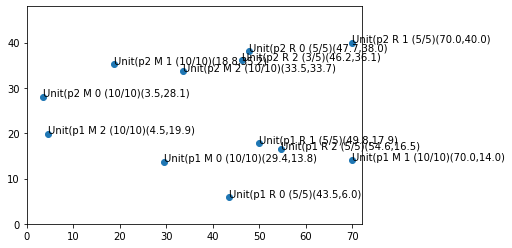

Units:
[Unit(p1 R 0 (5/5)(43.5,6.0),
 Unit(p1 R 1 (5/5)(49.8,17.9),
 Unit(p1 R 2 (5/5)(54.6,16.5),
 Unit(p1 M 0 (10/10)(29.4,13.8),
 Unit(p1 M 1 (10/10)(70.0,14.0),
 Unit(p1 M 2 (10/10)(4.5,19.9),
 Unit(p2 R 0 (5/5)(47.7,38.0),
 Unit(p2 R 1 (5/5)(70.0,40.0),
 Unit(p2 R 2 (3/5)(46.2,36.1),
 Unit(p2 M 0 (10/10)(3.5,28.1),
 Unit(p2 M 1 (10/10)(18.8,35.2),
 Unit(p2 M 2 (10/10)(33.5,33.7)]

Starting Round 2
Unit(p1 M 1 (10/10)(70.0,14.0) ('Rush', 12, 3.141592653589793)
Unit(p2 R 0 (5/5)(47.7,38.0) ('Advance', 6, -0.10275197975521146, Unit(p1 R 1 (5/5)(49.8,17.9))
Unit(p2 R 0 (5/5)(48.4,32.1) shooting at Unit(p1 R 1 (5/5)(49.8,17.9)
5 attacks
3 hits
2 wounds
Unit(p1 R 0 (5/5)(43.5,6.0) ('Advance', 6, -2.9584671793094284, Unit(p2 R 0 (5/5)(48.4,32.1))
Unit(p1 R 0 (5/5)(44.6,11.9) shooting at Unit(p2 R 0 (5/5)(48.4,32.1)
5 attacks
1 hits
1 wounds
Unit(p2 M 1 (10/10)(18.8,35.2) ('Rush', 12, 0.7509718519921905)
Unit(p1 R 1 (3/5)(49.8,17.9) ('Advance', 6, 3.038840673834582, Unit(p2 R 0 (4/5)(48.4

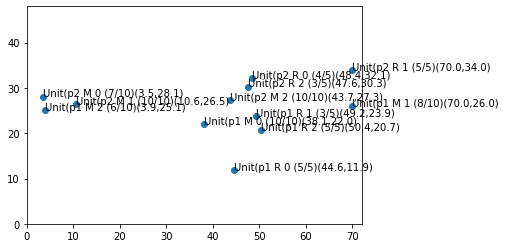

Units:
[Unit(p1 R 0 (5/5)(44.6,11.9),
 Unit(p1 R 1 (3/5)(49.2,23.9),
 Unit(p1 R 2 (5/5)(50.4,20.7),
 Unit(p1 M 0 (10/10)(38.1,22.0),
 Unit(p1 M 1 (8/10)(70.0,26.0),
 Unit(p1 M 2 (6/10)(3.9,25.1),
 Unit(p2 R 0 (4/5)(48.4,32.1),
 Unit(p2 R 1 (5/5)(70.0,34.0),
 Unit(p2 R 2 (3/5)(47.6,30.3),
 Unit(p2 M 0 (7/10)(3.5,28.1),
 Unit(p2 M 1 (10/10)(10.6,26.5),
 Unit(p2 M 2 (10/10)(43.7,27.3)]

Starting Round 3
Unit(p1 M 0 (10/10)(38.1,22.0) ('Charge', Unit(p2 M 2 (10/10)(43.7,27.3))
Unit(p1 M 0 (10/10)(42.3,25.9) strikes Unit(p2 M 2 (10/10)(43.7,27.3)
10 attacks
1 hits
1 wounds
Unit(p2 M 2 (9/10)(43.7,27.3) strikes Unit(p1 M 0 (10/10)(42.3,25.9)
9 attacks
3 hits
2 wounds
scores: a: 2, d: 3
p1 M 0 doing morale test
Unit(p2 M 1 (10/10)(10.6,26.5) ('Charge', Unit(p1 M 2 (6/10)(3.9,25.1))
Unit(p2 M 1 (10/10)(5.8,25.5) strikes Unit(p1 M 2 (6/10)(3.9,25.1)
10 attacks
3 hits
2 wounds
Unit(p1 M 2 (4/10)(3.9,25.1) strikes Unit(p2 M 1 (10/10)(5.8,25.5)
4 attacks
0 hits
0 wounds
scores: a: 4, d: 0
p1 M 2 d

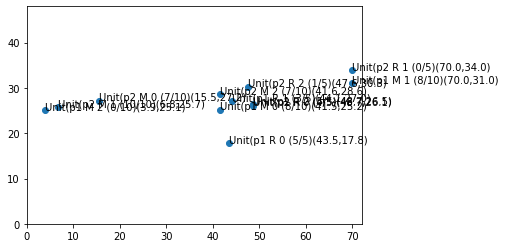

Units:
[Unit(p1 R 0 (5/5)(43.5,17.8),
 Unit(p1 R 1 (3/5)(44.1,27.0),
 Unit(p1 R 2 (5/5)(48.7,26.5),
 Unit(p1 M 0 (8/10)(41.5,25.2),
 Unit(p1 M 1 (8/10)(70.0,31.0),
 Unit(p1 M 2 (0/10)(3.9,25.1),
 Unit(p2 R 0 (4/5)(48.7,26.1),
 Unit(p2 R 1 (0/5)(70.0,34.0),
 Unit(p2 R 2 (1/5)(47.6,30.3),
 Unit(p2 M 0 (7/10)(15.5,27.2),
 Unit(p2 M 1 (10/10)(6.8,25.7),
 Unit(p2 M 2 (7/10)(41.6,28.6)]

Starting Round 4
Unit(p1 R 0 (5/5)(43.5,17.8) ('Advance', 6, -2.583937889153055, Unit(p2 R 0 (4/5)(48.7,26.1))
Unit(p1 R 0 (5/5)(46.7,22.9) shooting at Unit(p2 R 0 (4/5)(48.7,26.1)
5 attacks
0 hits
0 wounds
Unit(p2 R 0 (4/5)(48.7,26.1) ('Advance', 6, 3.0799731895855826, Unit(p1 R 2 (5/5)(48.7,26.5))
Unit(p2 R 0 (4/5)(48.4,32.1) shooting at Unit(p1 R 2 (5/5)(48.7,26.5)
4 attacks
0 hits
0 wounds
Unit(p1 R 2 (5/5)(48.7,26.5) ('Advance', 6, 2.8625966084683943, Unit(p2 R 2 (1/5)(47.6,30.3))
Unit(p1 R 2 (5/5)(47.1,32.3) shooting at Unit(p2 R 2 (1/5)(47.6,30.3)
5 attacks
1 hits
1 wounds
Unit(p2 M 2 (7/10)(41.6,28.6

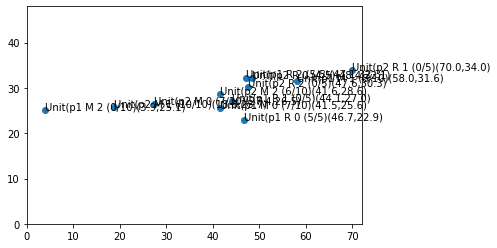

Units:
[Unit(p1 R 0 (5/5)(46.7,22.9),
 Unit(p1 R 1 (0/5)(44.1,27.0),
 Unit(p1 R 2 (5/5)(47.1,32.3),
 Unit(p1 M 0 (7/10)(41.5,25.6),
 Unit(p1 M 1 (8/10)(58.0,31.6),
 Unit(p1 M 2 (0/10)(3.9,25.1),
 Unit(p2 R 0 (4/5)(48.4,32.1),
 Unit(p2 R 1 (0/5)(70.0,34.0),
 Unit(p2 R 2 (0/5)(47.6,30.3),
 Unit(p2 M 0 (7/10)(27.4,26.5),
 Unit(p2 M 1 (10/10)(18.8,25.7),
 Unit(p2 M 2 (6/10)(41.6,28.6)]


In [1918]:
next_player = 0
for i in range(4):
    print()
    next_player = do_round(battle, next_player)
    plot_battle(battle)
    print("Units:")
    pprint(battle.all_units)

In [1919]:
def build_dwarven_army(playername):
    units = []
    
    # equipment
    hand_weapon = Weapon(1)
    rifle = Weapon(1, {"Range": 18, "AP": 1})
    champion_hand_weapon = Weapon(3, {"AP": 1})
    
    # Dwarf Champion
    units.append(Unit(
        [Model(3, 4, [champion_hand_weapon], rules={"Fearless":0, "Hero":0, "Slow":0, "Tough":3, "Fear":3})], 1, name="Hero"))
    
    dwarf_warrior = Model(4, 5, [hand_weapon], rules={"Shield Wall":0, "Slow":0})
    units.append(Unit(models_for(dwarf_warrior, 10), 5, name="Warriors"))
    
    heavy_hand_weapon = Weapon(1, {"AP": 1})
    veteran = Model(3, 4, [heavy_hand_weapon], rules={"Fearless":0, "Slow":0})
    units.append(Unit(models_for(veteran, 10), 5, name="Veterans"))
    
    great_weapon = Weapon(2, {"AP": 2})
    hammerer = Model(3, 4, [great_weapon], rules={"Slow":0})
    units.append(Unit(models_for(hammerer, 5), 5, name="Hammerers"))
    
    rifle_dwarf = Model(4, 5, [rifle, hand_weapon], rules={"Slow":0})
    units.append(Unit(models_for(rifle_dwarf, 5), 5, name="Marksmen"))
    
    fire_rifle = Weapon(2, {"Range": 18, "Rending": 0})
    drake_marksman = Model(3, 3, [fire_rifle, hand_weapon], rules={"Slow":0})
    units.append(Unit(models_for(drake_marksman, 5), 5, name="Drakes"))
    
    crew = Weapon(3)
    bolt_thrower = Weapon(1, {"Range": 36, "AP": 3, "Deadly":6})
    units.append(Unit([Model(4, 5, [crew, bolt_thrower], rules={"Immobile":0, "Entrenched":0, "Tough":3})], 1, name="Arty"))
    
    return units
build_dwarven_army("dwarves")

[Unit(Hero (1/1)(0.0,0.0),
 Unit(Warriors (10/10)(0.0,0.0),
 Unit(Veterans (10/10)(0.0,0.0),
 Unit(Hammerers (5/5)(0.0,0.0),
 Unit(Marksmen (5/5)(0.0,0.0),
 Unit(Drakes (5/5)(0.0,0.0),
 Unit(Arty (1/1)(0.0,0.0)]

In [1920]:
def build_elven_army(playername):
    units = []
    
    # equipment
    hand_weapon = Weapon(1)
    champion_hand_weapon = Weapon(3, {"AP": 1})
    
    # Dwarf Champion
    units.append(Unit(
        [Model(3, 4, [champion_hand_weapon], rules={"Hero":0, "Tough":3})], 1, name="Noble"))
    
    warrior = Model(4, 5, [hand_weapon])
    units.append(Unit(models_for(warrior, 10), 5, name="Elf Warriors"))
    
    heavy_halberds = Weapon(1, {"AP": 1, "Rending": 0})
    phoenix = Model(3, 4, [heavy_halberds], rules={"Regeneration":0})
    units.append(Unit(models_for(phoenix, 5), 5, name="Pheonix"))
    
    longbow = Weapon(1, {"Range": 30})
    archer = Model(4, 5, [hand_weapon, longbow])
    units.append(Unit(models_for(archer, 5), 5, name="Archers"))
    
    # Silver Cavalry
    lance = Weapon(1, {"Lance": 0})
    cavalry = Model(4, 4, [lance], rules={"Fast":0, "Impact":1})
    units.append(Unit(models_for(cavalry, 5), 5, name="Cavalry"))
    
    # Giant Eagles
    claws = Weapon(2)
    eagle = Model(4, 4, [claws], rules={"Fast":0, "Flying":0, "Impact":2, "Tough":3})
    units.append(Unit(models_for(eagle, 3), 3, name="Eagles"))
    
    axe_crew = Weapon(4)
    heavy_claw = Weapon(2, {"AP": 1})
    chariot = Model(4, 4, [heavy_claw, axe_crew], rules={"Fast":0, "Fear":1, "Fearless":0, "Impact":2, "Stealth":0, "Tough":6})
    units.append(Unit([chariot], 1, name="Chariot"))
    
    return units
build_elven_army("elves")

[Unit(Noble (1/1)(0.0,0.0),
 Unit(Elf Warriors (10/10)(0.0,0.0),
 Unit(Pheonix (5/5)(0.0,0.0),
 Unit(Archers (5/5)(0.0,0.0),
 Unit(Cavalry (5/5)(0.0,0.0),
 Unit(Eagles (3/3)(0.0,0.0),
 Unit(Chariot (1/1)(0.0,0.0)]

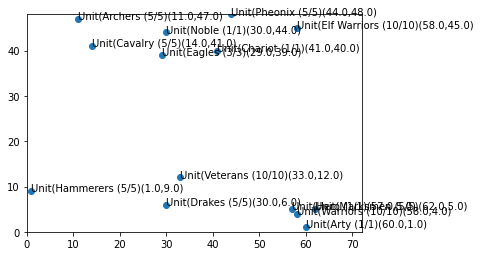

In [1921]:
p1 = Player("p1", build_dwarven_army("p1"), (0, 12, 0, 72))
p2 = Player("p2", build_elven_army("p2"), (36, 48, 0, 72))
battle = Battle([p1, p2])
deploy(battle)
plot_battle(battle)


Starting Round 1
Unit(Hero (1/1)(57.0,5.0) ('Rush', 8, 2.7128146261437767)
Unit(Pheonix (5/5)(44.0,48.0) ('Rush', 12, -0.26445230449446716)
Unit(Hammerers (5/5)(1.0,9.0) ('Rush', 8, -2.7557099841917196)
Unit(Eagles (3/3)(29.0,39.0) ('Rush', 16, -0.1470783553884025)
Unit(Drakes (5/5)(30.0,6.0) ('Advance', 4, -3.0634432473945035, Unit(Eagles (3/3)(31.3,23.2))
Unit(Drakes (5/5)(30.3,10.0) shooting at Unit(Eagles (3/3)(31.3,23.2)
10 attacks
5 hits
2 wounds
Unit(Elf Warriors (10/10)(58.0,45.0) ('Rush', 12, 0.13143597684203012)
Unit(Warriors (10/10)(58.0,4.0) ('Rush', 8, 3.08760718428624)
Unit(Archers (5/5)(11.0,47.0) ('Advance', 6, 0.22462975508867244, Unit(Hammerers (5/5)(4.0,16.4))
Unit(Archers (5/5)(9.7,41.2) shooting at Unit(Hammerers (5/5)(4.0,16.4)
5 attacks
3 hits
1 wounds
Unit(Marksmen (5/5)(62.0,5.0) ('Advance', 4, 2.945840126769912, Unit(Elf Warriors (10/10)(56.4,33.1))
Unit(Marksmen (5/5)(61.2,8.9) shooting at Unit(Elf Warriors (10/10)(56.4,33.1)
Out of range
Unit(Chariot (1/1)(

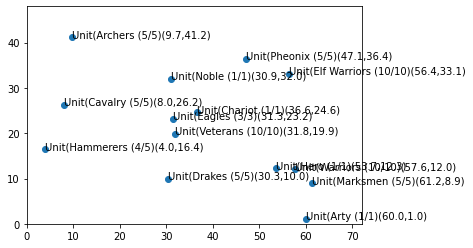

Units:
[Unit(Hero (1/1)(53.7,12.3),
 Unit(Warriors (10/10)(57.6,12.0),
 Unit(Veterans (10/10)(31.8,19.9),
 Unit(Hammerers (4/5)(4.0,16.4),
 Unit(Marksmen (5/5)(61.2,8.9),
 Unit(Drakes (5/5)(30.3,10.0),
 Unit(Arty (1/1)(60.0,1.0),
 Unit(Noble (1/1)(30.9,32.0),
 Unit(Elf Warriors (10/10)(56.4,33.1),
 Unit(Pheonix (5/5)(47.1,36.4),
 Unit(Archers (5/5)(9.7,41.2),
 Unit(Cavalry (5/5)(8.0,26.2),
 Unit(Eagles (3/3)(31.3,23.2),
 Unit(Chariot (1/1)(36.6,24.6)]

Starting Round 2
Unit(Arty (1/1)(60.0,1.0) ('Advance', 0, 3.030761942874057, Unit(Elf Warriors (10/10)(56.4,33.1))
Unit(Arty (1/1)(60.0,1.0) shooting at Unit(Elf Warriors (10/10)(56.4,33.1)
1 attacks
0 hits
0 wounds
Unit(Noble (1/1)(30.9,32.0) ('Rush', 12, -0.07573225809619602)
Unit(Drakes (5/5)(30.3,10.0) ('Advance', 4, -2.993536376934931, Unit(Noble (1/1)(31.8,20.1))
Unit(Drakes (5/5)(30.9,13.9) shooting at Unit(Noble (1/1)(31.8,20.1)
10 attacks
0 hits
0 wounds
Unit(Chariot (1/1)(36.6,24.6) ('Charge', Unit(Veterans (10/10)(31.8,19.9))


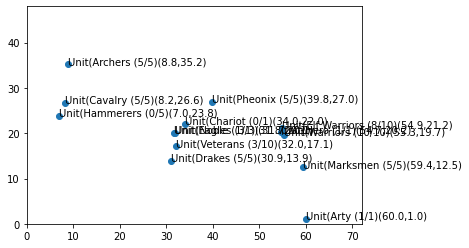

Units:
[Unit(Hero (1/1)(54.7,20.2),
 Unit(Warriors (10/10)(55.3,19.7),
 Unit(Veterans (3/10)(32.0,17.1),
 Unit(Hammerers (0/5)(7.0,23.8),
 Unit(Marksmen (5/5)(59.4,12.5),
 Unit(Drakes (5/5)(30.9,13.9),
 Unit(Arty (1/1)(60.0,1.0),
 Unit(Noble (1/1)(31.8,20.1),
 Unit(Elf Warriors (8/10)(54.9,21.2),
 Unit(Pheonix (5/5)(39.8,27.0),
 Unit(Archers (5/5)(8.8,35.2),
 Unit(Cavalry (5/5)(8.2,26.6),
 Unit(Eagles (3/3)(31.7,20.1),
 Unit(Chariot (0/1)(34.0,22.0)]

Starting Round 3
Unit(Arty (1/1)(60.0,1.0) ('Advance', 0, 2.8922574545618214, Unit(Elf Warriors (8/10)(54.9,21.2))
Unit(Arty (1/1)(60.0,1.0) shooting at Unit(Elf Warriors (8/10)(54.9,21.2)
1 attacks
0 hits
0 wounds
Unit(Elf Warriors (8/10)(54.9,21.2) ('Charge', Unit(Hero (1/1)(54.7,20.2))
Unit(Elf Warriors (8/10)(55.0,22.2) strikes Unit(Hero (1/1)(54.7,20.2)
8 attacks
4 hits
1 wounds
Unit(Hero (1/1)(54.7,20.2) strikes Unit(Elf Warriors (8/10)(55.0,22.2)
3 attacks
2 hits
1 wounds
scores: a: 2, d: 2
Unit(Marksmen (5/5)(59.4,12.5) ('Advance'

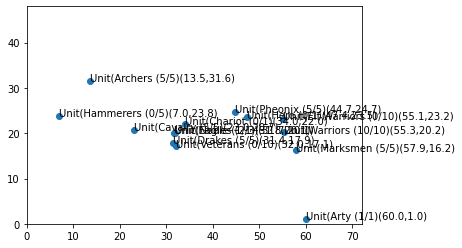

Units:
[Unit(Hero (0/1)(47.4,23.5),
 Unit(Warriors (10/10)(55.3,20.2),
 Unit(Veterans (0/10)(32.0,17.1),
 Unit(Hammerers (0/5)(7.0,23.8),
 Unit(Marksmen (5/5)(57.9,16.2),
 Unit(Drakes (5/5)(31.4,17.9),
 Unit(Arty (1/1)(60.0,1.0),
 Unit(Noble (1/1)(31.8,20.1),
 Unit(Elf Warriors (0/10)(55.1,23.2),
 Unit(Pheonix (5/5)(44.7,24.7),
 Unit(Archers (5/5)(13.5,31.6),
 Unit(Cavalry (5/5)(23.0,20.7),
 Unit(Eagles (2/3)(31.7,20.1),
 Unit(Chariot (0/1)(34.0,22.0)]

Starting Round 4
Unit(Marksmen (5/5)(57.9,16.2) ('Advance', 4, 2.144737936521469, Unit(Pheonix (5/5)(44.7,24.7))
Unit(Marksmen (5/5)(54.5,18.4) shooting at Unit(Pheonix (5/5)(44.7,24.7)
5 attacks
0 hits
0 wounds
Unit(Cavalry (5/5)(23.0,20.7) ('Charge', Unit(Drakes (5/5)(31.4,17.9))
Unit(Cavalry (5/5)(29.5,18.5) strikes Unit(Drakes (5/5)(31.4,17.9)
10 attacks
6 hits
4 wounds
Unit(Drakes (1/5)(31.4,17.9) strikes Unit(Cavalry (5/5)(29.5,18.5)
1 attacks
1 hits
1 wounds
scores: a: 4, d: 1
Drakes doing morale test
Unit(Drakes (1/5)(31.4,17.9)

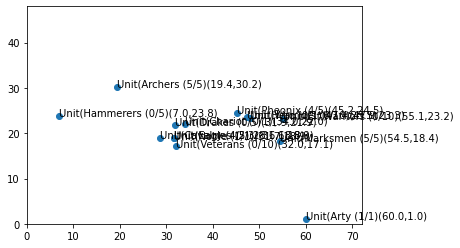

Units:
[Unit(Hero (0/1)(47.4,23.5),
 Unit(Warriors (6/10)(47.9,23.3),
 Unit(Veterans (0/10)(32.0,17.1),
 Unit(Hammerers (0/5)(7.0,23.8),
 Unit(Marksmen (5/5)(54.5,18.4),
 Unit(Drakes (0/5)(31.9,21.9),
 Unit(Arty (1/1)(60.0,1.0),
 Unit(Noble (1/1)(31.7,18.9),
 Unit(Elf Warriors (0/10)(55.1,23.2),
 Unit(Pheonix (4/5)(45.2,24.5),
 Unit(Archers (5/5)(19.4,30.2),
 Unit(Cavalry (4/5)(28.6,18.8),
 Unit(Eagles (2/3)(31.6,18.9),
 Unit(Chariot (0/1)(34.0,22.0)]


In [1922]:
next_player = 0
for i in range(4):
    print()
    next_player = do_round(battle, next_player)
    plot_battle(battle)
    print("Units:")
    pprint(battle.all_units)